## Capstone Project - Analysis of neighbourhoods of Schools in Toronto and their influence on student’s education


### Import necessary libraries

In [50]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!pip install folium
import folium # map rendering library
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

## Upload excel file containing school location and OSSLT results

In [3]:
filename=r'C:\Users\Subin\Documents\DS-Projects\School_data.xlsx'

In [4]:
df=pd.read_excel(filename)

In [5]:
df.head()

,Board Number,Board Name,Board Type,School Number,School Name,School Type,School Special Condition Code,School Level,School Language,Grade Range,...,Change in Grade 6 Mathematics Achievement Over Three Years,Percentage of Grade 9 Students Achieving the Provincial Standard in Academic Mathematics,Change in Grade 9 Academic Mathematics Achievement Over Three Years,Percentage of Grade 9 Students Achieving the Provincial Standard in Applied Mathematics,Change in Grade 9 Applied Mathematics Achievement Over Three Years,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt,Change in Grade 10 OSSLT Literacy Achievement Over Three Years,Percentage of Children Who Live in Low-Income Households,Percentage of Students Whose Parents Have Some University Education,Extract Date
0,B28010,Algoma DSB,Pub Dist Sch Brd (E/F),902344,Algoma Education Connection Secondary School,Public,Alternative,Secondary,English,9-12,...,NaN,N/D,NaN,N/R,NaN,N/R,NaN,22.7,20.5,2019-06-17
1,B28010,Algoma DSB,Pub Dist Sch Brd (E/F),019186,Anna McCrea Public School,Public,Not applicable,Elementary,English,JK-8,...,-36.0,NaN,NaN,NaN,NaN,NaN,NaN,11,56.3,2019-06-17
2,B28010,Algoma DSB,Pub Dist Sch Brd (E/F),067679,Arthur Henderson Public School,Public,Not applicable,Elementary,English,JK-3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.3,37.2,2019-06-17
3,B28010,Algoma DSB,Pub Dist Sch Brd (E/F),043362,Ben R McMullin Public School,Public,Not applicable,Elementary,English,JK-8,...,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,32,31.4,2019-06-17
4,B28010,Algoma DSB,Pub Dist Sch Brd (E/F),054542,Blind River Public School,Public,Not applicable,Elementary,English,JK-8,...,-11.0,NaN,NaN,NaN,NaN,NaN,NaN,24.8,19.8,2019-06-17


In [482]:
df.columns

Index(['Board Number', 'Board Name', 'Board Type', 'School Number',
       'School Name', 'School Type', 'School Special Condition Code',
       'School Level', 'School Language', 'Grade Range', 'Building Suite',
       'P.O. Box', 'Street', 'Municipality', 'City', 'Province', 'Postal Code',
       'Phone Number', 'Fax Number', 'School Website', 'Board Website',
       'Enrolment', 'Latitude', 'Longitude',
       'Percentage of Students Whose First Language Is Not English',
       'Percentage of Students Whose First Language Is Not French',
       'Percentage of Students Who Are New to Canada from a Non-English Speaking Country',
       'Percentage of Students Who Are New to Canada from a Non-French Speaking Country',
       'Percentage of Students Receiving Special Education Services',
       'Percentage of Students Identified as Gifted',
       'Percentage of Grade 3 Students Achieving the Provincial Standard in Reading',
       'Change in Grade 3 Reading Achievement Over Three Years

### Preprocessing school dataframe

In [6]:
# Create dataframe with required school information
df_school=df[['School Name','Postal Code','Latitude', 'Longitude','Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']]

In [7]:
df_school.head()

,School Name,Postal Code,Latitude,Longitude,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt
0,Algoma Education Connection Secondary School,P6B4J4,46.53477,-84.30772,N/R
1,Anna McCrea Public School,P6A3M7,46.50593,-84.28732,NaN
2,Arthur Henderson Public School,P0R1C0,46.30183,-83.78020,NaN
3,Ben R McMullin Public School,P6B5K2,46.52455,-84.29804,NaN
4,Blind River Public School,P0R1B0,46.18454,-82.95760,NaN


In [8]:
#Reduce length of postal code to first three letters
df_school['Postal Code']=df['Postal Code'].str[:3]

C:\Users\Subin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
df_school.head()

,School Name,Postal Code,Latitude,Longitude,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt
0,Algoma Education Connection Secondary School,P6B,46.53477,-84.30772,N/R
1,Anna McCrea Public School,P6A,46.50593,-84.28732,NaN
2,Arthur Henderson Public School,P0R,46.30183,-83.78020,NaN
3,Ben R McMullin Public School,P6B,46.52455,-84.29804,NaN
4,Blind River Public School,P0R,46.18454,-82.95760,NaN


In [10]:
# Drop all Null values
df_school=df_school.dropna()
df_school.reset_index(drop=True,inplace=True)

In [11]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 5 columns):
School Name                                                                     874 non-null object
Postal Code                                                                     874 non-null object
Latitude                                                                        874 non-null float64
Longitude                                                                       874 non-null float64
Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt    874 non-null object
dtypes: float64(2), object(3)
memory usage: 34.2+ KB


In [12]:
#remove the percentage symbol from the data in the column and convert it into float type.
df_school['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']=df_school['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt'].str[:2]

In [13]:
df_school['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt'] = pd.to_numeric(df_school['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt'],errors='coerce')

In [14]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 5 columns):
School Name                                                                     874 non-null object
Postal Code                                                                     874 non-null object
Latitude                                                                        874 non-null float64
Longitude                                                                       874 non-null float64
Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt    743 non-null float64
dtypes: float64(3), object(2)
memory usage: 34.2+ KB


In [15]:
#remove all Null values from the dataframe
df_school.dropna().head()

,School Name,Postal Code,Latitude,Longitude,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt
1,Central Algoma Secondary School,P0R,46.33811,-83.93551,64.0
2,Chapleau High School,P0M,47.84273,-83.40830,46.0
3,Elliot Lake Secondary School,P5A,46.37627,-82.66108,82.0
4,Hornepayne High School,P0M,49.21525,-84.77894,45.0
5,Korah Collegiate and Vocational School,P6C,46.54269,-84.38155,73.0


### Specify Wikipedia URL and send the GET request
### Use BeautifulSoup package for web scraping to parse the HTML data

In [16]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url,'lxml')

### Find the table containing postcodes

In [17]:
My_table = soup.find('table',{'class':'wikitable sortable'})

In [18]:
A=[]
B=[]
C=[]
for row in My_table.findAll('tr'):
    x=row.findAll('td')
    if len(x)==3:
        A.append(x[0].find(text=True))
        B.append(x[1].find(text=True))
        C.append(x[2].find(text=True))

### Loop through the rows to find the relevant data

In [19]:
df=pd.DataFrame()
df['PostCode']=A
df['Borough']=B
df['Neighborhood']=C
df.head()

,PostCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Clean data and transform data into a pandas dataframe

In [20]:
#Removing 'Not assigned' Boroughs and replacing 'Not assigned' neighborhoods with Borough name.
df.drop(df[df['Borough']=='Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x.strip())
df['Neighborhood'] = df['Neighborhood'].replace('Not assigned',df['Borough'])
df.head()

,PostCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [21]:
#Remove duplicate postcodes and combine Neighborhoods
df=df.groupby('PostCode', as_index=False).agg(lambda x: ', '.join(set(x.astype(str))))

## Merge both databases. 
### The below step adds the borough and neighborhood information to the data processed from school database. 

In [23]:
df_toronto=pd.merge(df_school,df,left_on='Postal Code', right_on='PostCode', how='right')

In [24]:
df_toronto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 187
Data columns (total 8 columns):
School Name                                                                     154 non-null object
Postal Code                                                                     154 non-null object
Latitude                                                                        154 non-null float64
Longitude                                                                       154 non-null float64
Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt    110 non-null float64
PostCode                                                                        188 non-null object
Borough                                                                         188 non-null object
Neighborhood                                                                    188 non-null object
dtypes: float64(3), object(5)
memory usage: 13.2+ KB


In [25]:
df_toronto.dropna(inplace=True)

In [26]:
df_toronto.reset_index(drop=True, inplace=True)

In [27]:
# Remove one of the postcode columns from the database since there are two such columns.
df_toronto=df_toronto.drop('PostCode',1)

In [28]:
df_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 7 columns):
School Name                                                                     110 non-null object
Postal Code                                                                     110 non-null object
Latitude                                                                        110 non-null float64
Longitude                                                                       110 non-null float64
Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt    110 non-null float64
Borough                                                                         110 non-null object
Neighborhood                                                                    110 non-null object
dtypes: float64(3), object(4)
memory usage: 6.1+ KB


### Create a box plot to show the distribution of the passing percentages of the schools

Text(0, 0.5, 'Percentage of Students that passed')

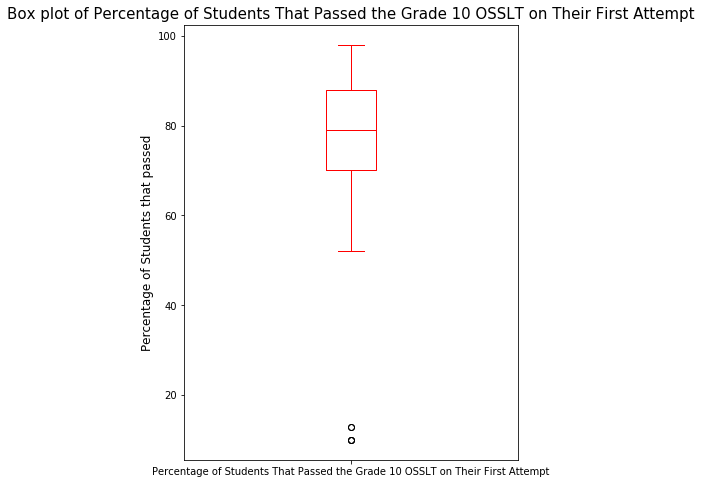

In [29]:
df_box=df_toronto['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']
df_box.plot(kind='box', figsize=(6, 8), color='red')
plt.title('Box plot of Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt', fontsize=15)
plt.ylabel('Percentage of Students that passed', fontsize=12)

In [30]:
#Removing outliers from our data
df_toronto.drop(df_toronto[df_toronto['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']<20].index,inplace=True)
df_toronto.dropna(inplace=True)
df_toronto.shape

(105, 7)

Text(0, 0.5, 'Percentage of Students that passed')

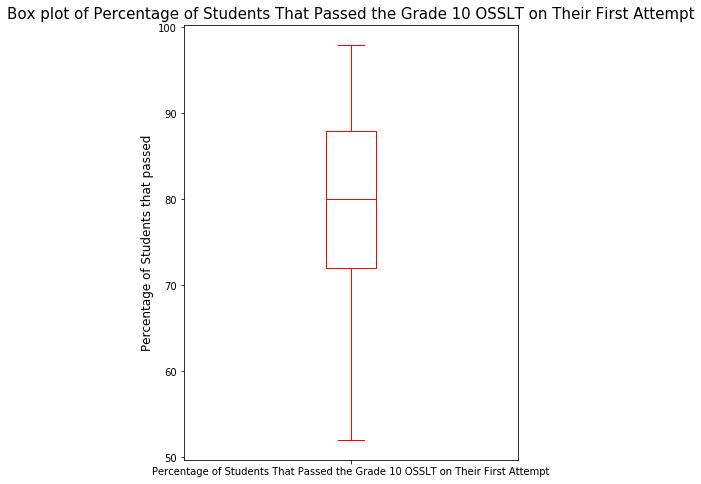

In [32]:
df_box=df_toronto['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']
df_box.plot(kind='box', figsize=(6, 8), color='red')
plt.title('Box plot of Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt', fontsize=15)
plt.ylabel('Percentage of Students that passed', fontsize=12)

### Create a map of Toronto and add markers to depict the schools.

In [34]:
# create map of Toronto using latitude and longitude values
lat_toronto= 43.651070
long_toronto= -79.347015
map_torontoGTA = folium.Map(location=[lat_toronto, long_toronto], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, school in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood'], df_toronto['School Name']):
    label = '{}, {}'.format(school, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_torontoGTA)  
    
map_torontoGTA

## In the next few steps, we extract the list of venues in a particular area from Foursquare

In [35]:
CLIENT_ID = 'K5U0CAU2CPLR3B00EGFIH3QX0GRJ5RUXPZ04HVZK2DKTX1O3' # your Foursquare ID
CLIENT_SECRET = 'LAJL20HDEIBSCNKM1QKR3TZIJKNX0WUMKLVNENLUAOEURYJJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500
LIMIT = 100

Your credentails:
CLIENT_ID: K5U0CAU2CPLR3B00EGFIH3QX0GRJ5RUXPZ04HVZK2DKTX1O3
CLIENT_SECRET:LAJL20HDEIBSCNKM1QKR3TZIJKNX0WUMKLVNENLUAOEURYJJ


### Explore venues around each school. Get the top 100 venues within a radius of 500 meters.

### Send the GET request. Clean the json and structure it into a pandas dataframe.

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['School Name', 
                  'School Latitude', 
                  'School Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [37]:
toronto_venues = getNearbyVenues(names=df_toronto['School Name'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Leaside High School
École secondaire Toronto Ouest
ÉSC Saint-Frère-André
Loretto College School
St Mary Catholic Academy Secondary School
Bloor Collegiate Institute
École secondaire Étienne-Brûlé
ÉSC Monseigneur-de-Charbonnel
Brebeuf College School
St. Joseph Morrow Park Catholic Secondary School
Newtonbrook Secondary School
Bishop Allen Academy Catholic Secondary School
Etobicoke School of the Arts
Bishop Marrocco/Thomas Merton Catholic Secondary School
Humberside Collegiate Institute
Western Technical & Commercial School
Blessed Cardinal Newman Catholic School
R H King Academy
Cardinal Carter Academy for the Arts
Earl Haig Secondary School
Chaminade College School
St Oscar Romero Catholic Secondary School
Dante Alighieri Academy
Father Henry Carr Catholic Secondary School
North Albion Collegiate Institute
West Humber Collegiate Institute
Father John Redmond Catholic Secondary School
Lakeshore Collegiate Institute
Francis Libermann Catholic High School
Agincourt Collegiate Institute
D

In [38]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


In [39]:
print(toronto_venues.shape)
toronto_venues.head()

(1492, 7)


,School Name,School Latitude,School Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Leaside High School,43.71107,-79.37291,Siam Square Hut,43.711387,-79.376201,Thai Restaurant
1,Leaside High School,43.71107,-79.37291,Rollian Sushi,43.712637,-79.376914,Japanese Restaurant
2,Leaside High School,43.71107,-79.37291,Riz,43.707541,-79.375880,Asian Restaurant
3,Leaside High School,43.71107,-79.37291,Metro,43.711273,-79.377837,Supermarket
4,Leaside High School,43.71107,-79.37291,Indian Street Food Co.,43.708032,-79.376086,Indian Restaurant


Venues returned for each neighborhood are one hot encoded

In [41]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to the beginning of the dataframe
col= toronto_venues['School Name']
toronto_onehot.insert(0, 'School Name', col)
toronto_onehot.head()


,School Name,Accessories Store,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Leaside High School,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Leaside High School,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Leaside High School,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Leaside High School,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Leaside High School,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
toronto_grouped = toronto_onehot.groupby('School Name').mean().reset_index()
toronto_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Columns: 239 entries, School Name to Yoga Studio
dtypes: float64(238), object(1)
memory usage: 194.3+ KB


In [43]:
num_top_venues = 5

for hood in toronto_grouped['School Name']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['School Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----A Y Jackson Secondary School----
                  venue  freq
0  Fast Food Restaurant   0.2
1   Housing Development   0.2
2                  Pool   0.2
3               Dog Run   0.2
4  Other Great Outdoors   0.2


----Agincourt Collegiate Institute----
                  venue  freq
0    Chinese Restaurant  0.30
1  Cantonese Restaurant  0.15
2      Asian Restaurant  0.15
3           Coffee Shop  0.05
4               Butcher  0.05


----Albert Campbell Collegiate Institute----
                venue  freq
0              Bakery  0.09
1  Chinese Restaurant  0.05
2         Pizza Place  0.05
3      Sandwich Place  0.05
4          Taco Place  0.05


----Birchmount Park Collegiate Institute----
                   venue  freq
0                   Park  0.29
1           Skating Rink  0.14
2        College Stadium  0.14
3  General Entertainment  0.14
4               Gym Pool  0.14


----Bishop Allen Academy Catholic Secondary School----
           venue  freq
0           Park  0.33
1  Moving T

### Sort the venues in descending order

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create new dataframe and display the top 10 venues in each School's neighborhood.

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['School Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
schools_venues_sorted = pd.DataFrame(columns=columns)
schools_venues_sorted['School Name'] = toronto_grouped['School Name']

for ind in np.arange(toronto_grouped.shape[0]):
    schools_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print(schools_venues_sorted.shape)
schools_venues_sorted.head()


(104, 11)


,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A Y Jackson Secondary School,Other Great Outdoors,Pool,Dog Run,Fast Food Restaurant,Housing Development,Yoga Studio,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
1,Agincourt Collegiate Institute,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant,Shopping Mall,Restaurant,Rental Car Location,Coffee Shop,Korean Restaurant,Vietnamese Restaurant,Butcher
2,Albert Campbell Collegiate Institute,Bakery,Ice Cream Shop,Movie Theater,Juice Bar,Taco Place,Liquor Store,Sporting Goods Shop,Spa,Fried Chicken Joint,Sandwich Place
3,Birchmount Park Collegiate Institute,Park,Gym Pool,Skating Rink,College Stadium,General Entertainment,Gym,Food & Drink Shop,Flower Shop,Food Court,Event Space
4,Bishop Allen Academy Catholic Secondary School,Moving Target,Locksmith,Park,Yoga Studio,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


### Run clustering algorithm k-means and determine optimal k value

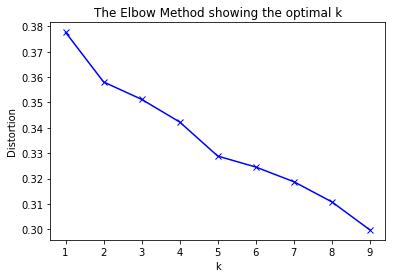

In [62]:
# k means determine optimal k using elbow method
distortions = []
toronto_grouped_clustering = toronto_grouped.drop('School Name', 1)
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [63]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('School Name', 1)

# run k-means clustering
kmeans = KMeans(init="k-means++",n_clusters=kclusters, n_init=12,random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 4, 0, 2, 0, 0, 0])

In [64]:
# add clustering labels
schools_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged=pd.merge(toronto_merged, schools_venues_sorted, on='School Name', how='inner')

toronto_merged.head()

,School Name,Postal Code,Latitude,Longitude,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Leaside High School,M4G,43.711070,-79.372910,97.0,East York,Leaside,0,Coffee Shop,Italian Restaurant,Road,American Restaurant,Pharmacy,Thai Restaurant,Snack Place,Indian Restaurant,Sandwich Place,Asian Restaurant
1,École secondaire Toronto Ouest,M6H,43.653344,-79.440959,98.0,West Toronto,"Dovercourt Village, Dufferin",0,Coffee Shop,Gastropub,Athletics & Sports,Clothing Store,Fast Food Restaurant,Restaurant,Brewery,Park,Auto Garage,Sandwich Place
2,ÉSC Saint-Frère-André,M6H,43.652510,-79.440640,97.0,West Toronto,"Dovercourt Village, Dufferin",0,Coffee Shop,Brewery,Gas Station,Grocery Store,Bar,Fast Food Restaurant,Restaurant,Gastropub,Auto Garage,Park
3,Loretto College School,M6H,43.664800,-79.411090,75.0,West Toronto,"Dovercourt Village, Dufferin",0,Korean Restaurant,Grocery Store,Bakery,Coffee Shop,Eastern European Restaurant,Restaurant,Mexican Restaurant,Ice Cream Shop,Japanese Restaurant,Café
4,St Mary Catholic Academy Secondary School,M6H,43.657750,-79.431810,70.0,West Toronto,"Dovercourt Village, Dufferin",0,Bakery,Clothing Store,Coffee Shop,Pizza Place,Bar,African Restaurant,Restaurant,Skating Rink,Mexican Restaurant,Market


### Create map of Toronto with the schools labeled as per their cluster

In [80]:
# create map
map_clusters = folium.Map(location=[lat_toronto, long_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['School Name'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### List of schools in Cluter 0

In [66]:
cluster0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

cluster0[['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']].describe()
cluster0

,School Name,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Leaside High School,97.0,East York,Leaside,0,Coffee Shop,Italian Restaurant,Road,American Restaurant,Pharmacy,Thai Restaurant,Snack Place,Indian Restaurant,Sandwich Place,Asian Restaurant
1,École secondaire Toronto Ouest,98.0,West Toronto,"Dovercourt Village, Dufferin",0,Coffee Shop,Gastropub,Athletics & Sports,Clothing Store,Fast Food Restaurant,Restaurant,Brewery,Park,Auto Garage,Sandwich Place
2,ÉSC Saint-Frère-André,97.0,West Toronto,"Dovercourt Village, Dufferin",0,Coffee Shop,Brewery,Gas Station,Grocery Store,Bar,Fast Food Restaurant,Restaurant,Gastropub,Auto Garage,Park
3,Loretto College School,75.0,West Toronto,"Dovercourt Village, Dufferin",0,Korean Restaurant,Grocery Store,Bakery,Coffee Shop,Eastern European Restaurant,Restaurant,Mexican Restaurant,Ice Cream Shop,Japanese Restaurant,Café
4,St Mary Catholic Academy Secondary School,70.0,West Toronto,"Dovercourt Village, Dufferin",0,Bakery,Clothing Store,Coffee Shop,Pizza Place,Bar,African Restaurant,Restaurant,Skating Rink,Mexican Restaurant,Market
5,Bloor Collegiate Institute,92.0,West Toronto,"Dovercourt Village, Dufferin",0,Bar,Bakery,Café,Coffee Shop,Sandwich Place,Mexican Restaurant,Clothing Store,Cocktail Bar,Beer Store,Caribbean Restaurant
6,École secondaire Étienne-Brûlé,85.0,North York,"Silver Hills, York Mills",0,Pool,Martial Arts Dojo,Park,Lawyer,Falafel Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
7,ÉSC Monseigneur-de-Charbonnel,95.0,North York,"Willowdale, Newtonbrook",0,Coffee Shop,Indian Restaurant,Korean Restaurant,Café,Bank,Food & Drink Shop,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Flower Shop
8,St. Joseph Morrow Park Catholic Secondary School,62.0,North York,"Willowdale, Newtonbrook",0,Park,Intersection,Grocery Store,Fast Food Restaurant,Event Space,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
9,Newtonbrook Secondary School,76.0,North York,"Willowdale, Newtonbrook",0,Coffee Shop,Vietnamese Restaurant,Korean Restaurant,Discount Store,Café,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Sandwich Place,Beer Store


### List of schools in Cluter 1

In [67]:
cluster1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
cluster1[['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']].describe()
cluster1

,School Name,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,West Hill Collegiate Institute,73.0,Scarborough,"West Hill, Morningside, Guildwood",1,Pool,Yoga Studio,Event Space,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
103,York Mills Collegiate Institute,96.0,North York,Don Mills North,1,Pool,Yoga Studio,Event Space,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop


### List of schools in Cluter 2

In [69]:
cluster2= toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
cluster2[['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']].describe()
cluster2

,School Name,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Father Henry Carr Catholic Secondary School,60.0,Etobicoke,"Mount Olive, Beaumond Heights, Albion Gardens,...",2,Bus Line,Food Court,Pizza Place,Grocery Store,Yoga Studio,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food & Drink Shop
24,West Humber Collegiate Institute,74.0,Etobicoke,"Mount Olive, Beaumond Heights, Albion Gardens,...",2,Bus Line,Grocery Store,Yoga Studio,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


### List of schools in Cluter 3

In [70]:
cluster3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
cluster3[['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt']].describe()
cluster3

,School Name,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Loretto Abbey Catholic Secondary School,90.0,North York,"Bedford Park, Lawrence Manor East",3,Pub,Event Space,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Financial or Legal Service


### List of schools in Cluter 4

In [71]:
cluster4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
cluster4

,School Name,Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Earl Haig Secondary School,93.0,North York,Willowdale South,4,Hotel,Coffee Shop,Grocery Store,Discount Store,Yoga Studio,Flower Shop,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Food Court
20,St Oscar Romero Catholic Secondary School,53.0,North York,"Upwood Park, North Park, Downsview",4,Furniture / Home Store,Home Service,Seafood Restaurant,Coffee Shop,Park,Diner,Disc Golf,Fried Chicken Joint,French Restaurant,Food Truck
23,North Albion Collegiate Institute,79.0,Etobicoke,"Mount Olive, Beaumond Heights, Albion Gardens,...",4,Financial or Legal Service,Caribbean Restaurant,Coffee Shop,Park,Yoga Studio,Falafel Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
31,C W Jefferys Collegiate Institute,63.0,North York,"York University, Northwood Park",4,Scenic Lookout,Bus Stop,Baseball Field,Coffee Shop,Yoga Studio,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
32,Jean Vanier Catholic Secondary School,56.0,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",4,Burger Joint,Discount Store,Pizza Place,Coffee Shop,Fast Food Restaurant,Farmers Market,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
41,Silverthorn Collegiate Institute,82.0,Etobicoke,"Eringate, Bloordale Gardens, Markland Wood, Ol...",4,Pharmacy,Coffee Shop,Park,Beer Store,Flower Shop,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Yoga Studio,Falafel Restaurant
52,Neil McNeil High School,80.0,East Toronto,The Beaches,4,Coffee Shop,Pub,Burger Joint,Gastropub,Sandwich Place,Beer Store,Caribbean Restaurant,Bar,Pizza Place,Food Court
55,Senator O'Connor College School,80.0,North York,Parkwoods,4,Restaurant,Tennis Court,Coffee Shop,Medical Center,Pharmacy,Yoga Studio,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Food & Drink Shop
74,Martingrove Collegiate Institute,86.0,Etobicoke,"Martin Grove, Islington, Cloverdale, West Dean...",4,Coffee Shop,Supermarket,Pharmacy,Liquor Store,Yoga Studio,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
76,Kipling Collegiate Institute,59.0,Etobicoke,"Martin Grove Gardens, St. Phillips, Richview G...",4,Sandwich Place,Coffee Shop,Pizza Place,Liquor Store,Pharmacy,Financial or Legal Service,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Food & Drink Shop


### Create a table listing the frequency of occurence of the 1st most common venues in each cluster

In [73]:
df1=pd.DataFrame(cluster1['1st Most Common Venue'].value_counts())
df1.index.name='Venue'

In [74]:
df2=pd.DataFrame(cluster2['1st Most Common Venue'].value_counts())
df2.index.name='Venue'

In [75]:
df3=pd.DataFrame(cluster3['1st Most Common Venue'].value_counts())
df3.index.name='Venue'

In [76]:
df0=pd.DataFrame(cluster0['1st Most Common Venue'].value_counts())
df0.index.name='Venue'

In [77]:
df4=pd.DataFrame(cluster4['1st Most Common Venue'].value_counts())
df4.index.name='Venue'

In [78]:
# Merge the dataframes into one
df12=pd.merge(pd.merge(df0, df1, on='Venue', how='outer'), pd.merge(df2,df3,on='Venue',how='outer'),on='Venue',how='outer')
df12.rename(columns={'1st Most Common Venue_x_x':'Cluster 0',
                          '1st Most Common Venue_y_x':'Cluster 1',
                          '1st Most Common Venue_x_y':'Cluster 2', '1st Most Common Venue_y_y':'Cluster 3'}, 
                 inplace=True)
df34=pd.merge(df12,df4,on='Venue',how='outer')
df34.rename(columns={'1st Most Common Venue':'Cluster 4'},inplace=True)

df34 = df34.replace(np.NaN,'')
df34

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Venue,,,,,
Coffee Shop,12,,,,5
Bakery,5,,,,
Fast Food Restaurant,5,,,,
Pizza Place,5,,,,
Park,4,,,,
Chinese Restaurant,4,,,,
Sandwich Place,3,,,,2
Pub,3,,,1,
Event Space,2,,,,


### Analysis on percentage of students that passed in schools in each cluster

In [79]:
df_analysis=pd.DataFrame(columns=['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'])
df_analysis['Cluster 0']=cluster0['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt'].describe()
df_analysis['Cluster 1']=cluster1['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt'].describe()
df_analysis['Cluster 2']=cluster2['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt'].describe()
df_analysis['Cluster 3']=cluster3['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt'].describe()
df_analysis['Cluster 4']=cluster4['Percentage of Students That Passed the Grade 10 OSSLT on Their First Attempt'].describe()
df_analysis = df_analysis.replace(np.NaN,'')
df_analysis

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
count,83.000000,2.000000,2.000000,1,16.000000
mean,79.843373,84.500000,67.000000,90,76.000000
std,11.691650,16.263456,9.899495,,12.606876
min,52.000000,73.000000,60.000000,90,53.000000
25%,72.000000,78.750000,63.500000,90,68.250000
50%,80.000000,84.500000,67.000000,90,79.500000
75%,89.000000,90.250000,70.500000,90,83.000000
max,98.000000,96.000000,74.000000,90,94.000000
